# Deep Learning

Projet d'entrainement de reconnaissance de famille d'animaux fait par Kamel AÏT AHMED et Florent Dijoux

Nous avons choisit la reconnaissance de famille d'animaux car ce sujet nous permet de d'avoir une grande diversité d'image non seulement à l'entrainement mais aussi à tester par la suite. Ici, il n'y aura pas que la couleur qui comptera lors de la phase de test, la forme joue également un rôle.



In [1]:
#Import des bibliothèque pour le projet

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img

from keras import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import optimizers

from sklearn.model_selection import train_test_split

from PIL import Image

import os
import glob
import numpy as np

Using TensorFlow backend.


In [2]:
vgg = VGG16()

### Creating a dataset

In [3]:
#Création des variables (dossier du dataset et des images test +
# nombre de classe)

folder = '../img/Animals'
folderTest = '../img/TestAnimals'
np_class = len(os.listdir(folder))

#### TODO: refator this function, "def create_dataset(folder): .... return X, Y"

In [4]:
#Création du dataset

def create_dataset(folder): 
    
    #CREATE TABLE
    all_images = []
    image_arrays = []
    all_labels = []
    filenames = []
    for class_id, label in enumerate(os.listdir(folder)):
        print(class_id, label)
        for filename in glob.glob(folder + '/{}/*'.format(label)):
            filenames.append(filename)
            im = load_img(filename, target_size=(224, 224))
            all_images.append(im) 
            image_arrays.append(preprocess_input(img_to_array(im)))
            all_labels.append(class_id)
    X = np.array(image_arrays).astype(int)
    Y = to_categorical(np.array(all_labels))


    return X, Y

In [5]:
X, Y = create_dataset(folder)

0 birds
1 feline
2 insect
3 reptile


c:\users\kamel\developpement\deaplearning\my_project\myenv\lib\site-packages\PIL\Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.15, random_state=42)

### Transfer learning

In [12]:
# Charger VGG-16 pré-entraîné sur ImageNet
# mais sans les couches fully-connected
vgg_cut = VGG16(weights="imagenet", include_top=False,
                input_shape=(224, 224, 3))

x = vgg_cut.output

# Ajout des couches
x = Flatten()(x)
x = Dense(30, activation='relu')(x) 
x = Dense(np_class, activation='softmax')(x)  

In [13]:
#création du model custom 
custom_model = Model(inputs=vgg_cut.input, outputs=x)

In [14]:
# stratégie de Transfer Learning: extraction de features
# On entraîne seulement le nouveau classifieur,
# et on ne ré-entraîne pas les autres couches.
# On utilise les autres couches uniquement pour 
# extraire des features des images
for layer in custom_model.layers[:-2]:
    layer.trainable = False

In [15]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
# Compiler le modèle 
custom_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

In [17]:
# Entraîner sur toutes les données
# (X_train, Y_train)
# On initialise batch_size à 10 afin d'avoir 10 image traité à chaque fois
custom_model.fit(X_train, Y_train,
                 epochs=5, batch_size=10)

Epoch 1/5
601/601 [==============================] - 389s 646ms/step - loss: 5.1245 - acc: 0.6423
Epoch 2/5
601/601 [==============================] - 369s 613ms/step - loss: 4.1590 - acc: 0.7271
Epoch 3/5
601/601 [==============================] - 349s 581ms/step - loss: 4.0366 - acc: 0.7438
Epoch 4/5
601/601 [==============================] - 356s 592ms/step - loss: 3.8945 - acc: 0.7521
Epoch 5/5
601/601 [==============================] - 404s 672ms/step - loss: 3.9114 - acc: 0.7537


#### Utilisons notre modèle entrainé pour faire des prédiction sur les images de test
#### TODO! écrire le code qui charge des photos du nouveau dossier, img_test, qui n'a pas été utilisé pour l'entrainement!

In [ ]:
# Voici la fonction qui nous permettra de charger les images a partir d'un dossier de test qui n'a pas été
# utilisé a l'entrainement.

In [35]:
def getFolderTest(folder): 
    all_images = []
    image_arrays = []
    all_labels = []
    filenames = []

    for class_id, label in enumerate(os.listdir(folderTest)):
        for filename in glob.glob(folderTest + '/{}/*'.format(label)):
            filenames.append(filename)
            im = load_img(filename, target_size=(224, 224))
            all_images.append(im) 
            image_arrays.append(preprocess_input(img_to_array(im)))
            all_labels.append(class_id)
        X_test = np.array(image_arrays).astype(int)
    return X_test

In [36]:
test = getFolderTest(folderTest)
image = array_to_img(test[13])

# Lancement de la prédiction sur l'image 13
custom_model.predict(test[13].reshape(1, *test[13].shape))

array([[1.0000000e+00, 0.0000000e+00, 5.8781258e-27, 0.0000000e+00]],
      dtype=float32)

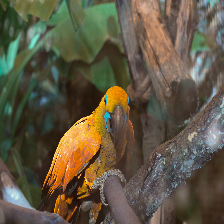

In [37]:
image

In [127]:
# On voit que l'image est bien un oiseau ce qui nous montre que la reconnaissance a bien fonctionnée,
# en effet le dossier représentant les oiseaux est le premier. En lancant la fonction predict on a le
# meilleur résultat de la première cellule du tableau.

In [128]:
# On réalise un nouveau test sur nouvelle image qui n'a jamais été apprise par le module

In [38]:
image1 = array_to_img(test[5])

custom_model.predict(test[5].reshape(1, *test[5].shape))

array([[2.8793887e-32, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)

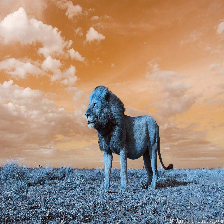

In [39]:
image1

In [50]:
# Après l'appel a la fonction sur une nouvelle image, on peux voir que le résultat de la prédiction est en 
# concordance avec l'affichage de l'image. En effet ceci est bien un félin, la prédiction nous renvoie vers
# le deuxième dossier qui est bien celui des félins.

# Projet
1. Trouver le sujet de classification d'images
2. Créer le jeu de données:
    * Télécharger les images de l'Internet
    * Utiliser le plugin de navigateur pour aller plus vite:
    * Saisir la requete sur Google Images (par exemple)
    * Cliquer sur "Download All Images" (le plugin du navigateur)
    * Dézipper le fichier téléchargé
    * Récupérer seulement des images pertinentes
    * Mettre ces images dans votre arboscence:
        "img/<nom_de_l_equipe>/<un_dossier_par_catégorie>/*.png"
    * Créer des matrices X et Y à partir des images:
        * itérateur sur les dossiers et les images;
        * chargement des images;
        * preprocessing lié à VGG16 (ou autre modèle CNN préentrainé que vous allez utiliser);
        * création du numpy.array finale depuis la liste des images chargés et prétraités;
        * création du vecteur de "labels" à partir des noms de dossiers parcourus, pour chaque image ("adidas adidas adidas cocacola cocacola fdj fdj fdj fdj ....");
        * conversion du vecteur 1-dimensionnel de labels en vecteur M-dimensionnel, où M = nombre de catégories de votre problème: pour cela, utiliser la fonction *to_categorical*. Chaque label doit donc être un vecteur avec des 0.0 et une seule valeur 1.0 sur la position qui correspond à la bonne catégorie.
        
3. Utiliser un des modèles CNN (convolutional neural network) déjà entrainé (comme VGG ou autre, cf. ici https://keras.io/applications/) pour faire des prédictions sur quelques images de votre dataset. Utiliser "decode_predictions" pour afficher à quelles classes appartient des valeurs maximales du vecteur de prédiction

* Comme votre use case est spécifique, et les classes présentes dans le modèle VGG ne correspondent pas à votre problème. Il faut donc faire du Transfer Learning:
    * Prendre un modèle pré-entrainé (VGG par exemple), mais ne pas utiliser sa dernière couche! (include_top=False). Ne pas oublier de spécifier le format des images en entrée ((224, 224, 3) pour VGG). 
    * Ajouter une couche Flatten() pour aplaitir la matrice pour obtenir le vecteur 1-dimensionnel.
    * Ajouter une couche Dense(nb_classes, activation="softmax")
    * Créer un modele *custom* qui va utiliser ces couches-là.
    * Comme le modèle VGG sera en version "cut" ("truncated"), donc elle ne sera pas utilisé pour les prédictions mais seulement pour extraction de features. Donc, il faut préciser que les couches du modèle custom soit déclarés comme "layer.trainable = False". Utiliser l'itérateur sur "custom_model.layers" afin de préciser quelles couches ne pas entrainer.
    * Vérifier avec "custom_model.summary()" que seulement les paramètres qui correspondent à la dernière couche Dense seront entrainés (cf. les messages "Total parameters, Trainable parameters, Non-Trainable parameters" du summary.
    * Déclarer la méthod de "compilation" du modèle (fonction de perte, algorithme, métrique) avec "custom_model.compile(....)"
    * Finalement, ENTRAINER le modèle avec la commande "custom_modèle.fit". Utiliser plusieurs nombre de *epochs* (plus est mieux, quitte à laisser le modèle s'entrainer pendant plusieurs heures); varier le *batch_size* en fonction de nombre totale d'images dans votre dataset (batch_size plus élevé accélère l'entrainement mais dégrade le résultat; par contre valeur 1 risque de finir par le "overfit", "surapprentissage", où le modèle va apprendre par coeur des exemple, mais mal généraliser sur des nouvelles images, donc le score sera mauvais aussi. Trouver la bonne valeur de batch_size, commenter les étapes de votre expérimentation.
    
    
* Charger des images depuis le dossier "img/test_images", utiliser le même prétraitement afin d'avoir le même format que des matrices X (pas besoin de Y ici, car vous allez juste lancer des prédictions).
* Lancer des prédictions sur ces nouvelles images (custom_model.predict).
* Interpréter des prédictions. Quelle catégorie donne la proba maximale?  Afficher l'image dans notebook pour voir ce qu'elle représente. Est-ce que c'est la bonne catégorie qui a été prédite?


#### Faire un résumé du projet: qu'est-ce que vous avez fait, quels résultats obtenus. Quel score a votre modèle, est-ce qu'elle prédit bien sur des images de test.
#### Commentez votre code!!! 
    
### livrables: GITHUB!!! code + images, la même arborescence que dl 
### denis.lazarenko@gmail.com
~~deadline: 3 mars 2019 , 23:59:59~~

désolé d'avoir envoyé une mauvaise version du fichier vendredi dernier

on va donc avancer la deadline
### deadline: 10 mars 2019 , 23:59:59
### questions  par mail ou slack


#### Liens utils
* training Keras models: 
  https://keras.io/getting-started/sequential-model-guide/
* deep learning tutorial: https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
* convolution filter produces a feature map (animation): https://www.youtube.com/watch?v=KiftWz544_8